# Predicting credit card fraud with autoencoders

Credit card fraud is a complicated problem:

- The data set is hugely imbalanced.
- Low quality of labeled data => fraud patterns hard to find.

We will give it a try to a neural network technique called *autoencoders*.

Originally used for computer vision, autoencoders can also be used in other applications, such as fraud detection.

#### 1. Read some data

We will import some data from the data science website Kaggle (https://www.kaggle.com/mlg-ulb/creditcardfraud).

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv("./data/creditcard.csv")

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### 2. Exploratory Data Analysis

We perform some basic sanity checks: how many examples do we have of each class, and how do the distributions look like?

In [8]:
df.groupby(['Class'])['Class'].count()

Class
0    284315
1       492
Name: Class, dtype: int64

We have 492 fraudulent transactions against 28k...

Class
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Class, dtype: object

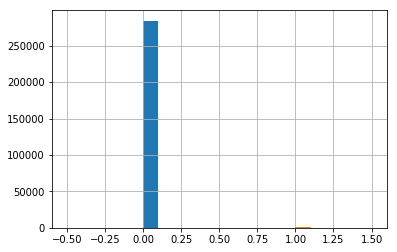

In [9]:
%matplotlib inline
df.groupby(['Class'])['Class'].hist()

In [10]:
fraud = df[df['Class']==1]
normal = df[df['Class']==0]

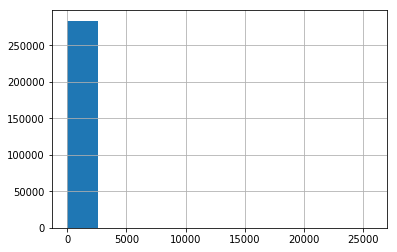

In [11]:
normal['Amount'].hist()

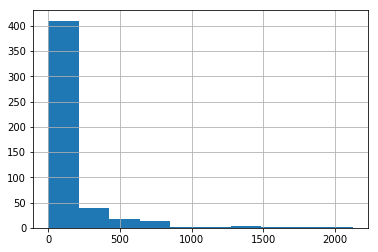

In [12]:
fraud['Amount'].hist()

Interestingly, we see that fraudulent transactions are slightly higher than average, but not that much. Probably this is done by the criminals to remain unnoticed.

#### 3. Rescale the data

For many models, specially those that are based on gradient estimates, it is important to rescale the data. 

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
scl = StandardScaler()

In [15]:
normal['Amount'] = scl.fit_transform(normal['Amount'].values.reshape(-1,1))

C:\Users\pablo\Anaconda3\envs\packt\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
normal.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.245213,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342261,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160990,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140777,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073173,0


In [17]:
X = normal.drop(['Class','Time'], axis=1)

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test = train_test_split(X, test_size=0.2)

#### 4. Building the model

Let's use `keras` to create our autoencoder network.

Note that the model will be trained **only** in non-fraudulent data: this will abstract out the features of normal transactions, so that we can identify the outliers.


In [20]:
from keras.layers import Input, Dense
from keras.models import Model

C:\Users\pablo\Anaconda3\envs\packt\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [21]:
X_train.shape

(227452, 29)

In [22]:
input_dim = X_train.shape[1]

In [23]:
inner_dim = int(input_dim/2)

In [24]:
inner_dim

14

In [25]:
input_layer = Input(shape=(input_dim,))

In [26]:
encoder = Dense(inner_dim, activation = 'tanh')(input_layer)

In [27]:
decoder = Dense(input_dim, activation='relu')(encoder)

In [28]:
autoencoder = Model(inputs = input_layer, outputs=decoder)

In [29]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 29)                435       
Total params: 855
Trainable params: 855
Non-trainable params: 0
_________________________________________________________________


#### 5. Compile and train the model

In [30]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [31]:
history = autoencoder.fit(X_train, X_train, 
                         epochs = 2, 
                         batch_size = 32).history

Epoch 1/2
227452/227452 [==============================] - 6s 25us/step - loss: 0.6877 - acc: 0.7411
Epoch 2/2
227452/227452 [==============================] - 7s 30us/step - loss: 0.6297 - acc: 0.8139


In [32]:
import numpy as np

In [33]:
fraud['Amount'] = scl.transform(fraud['Amount'].values.reshape(-1,1))

C:\Users\pablo\Anaconda3\envs\packt\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### 6. Generate predictions and evaluate model performance.

Autoencoders do not provide labels! Instead, we need to measure the reconstruction error and set some thresholds: if the reconstruction error is too large, that means that the class is different from the class the model was trained on.

In [34]:
true_fraud = fraud['Class'].values

In [35]:
X_fraud = fraud.drop(['Class','Time'], axis=1)

In [36]:
preds = autoencoder.predict(X_fraud)

In [37]:
mse = np.mean(np.power(X_fraud-preds,2), axis=1)

In [38]:
mse.describe()

count    492.000000
mean      27.164779
std       37.401792
min        0.106303
25%        4.641566
50%       10.917558
75%       27.467991
max      279.186643
dtype: float64

In [53]:
threshold = 0.4

In [54]:
suspicious = np.where(mse>=threshold, 1, 0)

In [55]:
suspicious

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [59]:
print("Fraud cases that we missed: ", np.sum(suspicious!=true_fraud)/len(true_fraud)*100)

Fraud cases that we missed:  4.0650406504065035
